<a href="https://colab.research.google.com/github/pratikiiitb2013/Amplify_Demo/blob/main/Dell_AmplifyProgram_NLP_NN_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import re

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [2]:
df = pd.read_excel('/content/dici_with_levels - Main training dataset.xlsx')

df['OPP_NM_cleanUp'] = [re.sub('[^\x00-\x7F]+', '', str(_)) for _ in df.OPP_NM]
df['OPP_NM_cleanUp'] = [re.sub('\W+|_', ' ', str(_)) for _ in df.OPP_NM_cleanUp]
df['OPP_NM_cleanUp'] = [re.sub('\w*\d\w*', '', str(_)) for _ in df.OPP_NM_cleanUp]

df['SLTN_NM_DESC'] = [re.sub('[^\x00-\x7F]+', '', str(_)) for _ in df.SLTN_NM_DESC]
df['SLTN_NM_DESC'] = [re.sub('\W+|_', ' ', str(_)) for _ in df.SLTN_NM_DESC]
df['SLTN_NM_DESC'] = [re.sub('\w*\d\w*', '', str(_)) for _ in df.SLTN_NM_DESC]

df['SLTN_TYPE_DESC'] = [re.sub('[^\x00-\x7F]+', '', str(_)) for _ in df.SLTN_TYPE_DESC]
df['SLTN_TYPE_DESC'] = [re.sub('\W+|_', ' ', str(_)) for _ in df.SLTN_TYPE_DESC]
df['SLTN_TYPE_DESC'] = [re.sub('\w*\d\w*', '', str(_)) for _ in df.SLTN_TYPE_DESC]

df['DELL_ACCT_NAME'] = [re.sub('[^\x00-\x7F]+', '', str(_)) for _ in df.DELL_ACCT_NAME]
df['DELL_ACCT_NAME'] = [re.sub('\W+|_', ' ', str(_)) for _ in df.DELL_ACCT_NAME]
df['DELL_ACCT_NAME'] = [re.sub('\w*\d\w*', '', str(_)) for _ in df.DELL_ACCT_NAME]

df.OPP_NM_cleanUp = df.OPP_NM_cleanUp.replace('\s+', ' ', regex=True)
df.SLTN_NM_DESC = df.SLTN_NM_DESC.replace('\s+', ' ', regex=True)
df.SLTN_TYPE_DESC = df.SLTN_TYPE_DESC.replace('\s+', ' ', regex=True)
df.DELL_ACCT_NAME = df.DELL_ACCT_NAME.replace('\s+', ' ', regex=True)

df['OPP_NM_cleanUp'] = df['OPP_NM_cleanUp'].str.lower()
df['SLTN_NM_DESC'] = df['SLTN_NM_DESC'].str.lower()
df['SLTN_TYPE_DESC'] = df['SLTN_TYPE_DESC'].str.lower()
df['DELL_ACCT_NAME'] = df['DELL_ACCT_NAME'].str.lower()

df['FLG'] = df.apply(lambda x: x.DELL_ACCT_NAME in x.OPP_NM_cleanUp, axis=1)
df['Combined_OPP_NM_ACC_NM'] = np.where(df['FLG']==False, df['OPP_NM_cleanUp'] + ' ' + df['DELL_ACCT_NAME'], df['OPP_NM_cleanUp'])
df['final_combined'] = df['Combined_OPP_NM_ACC_NM'] + " " + df['SLTN_NM_DESC'].fillna('') + " " + df['SLTN_TYPE_DESC'].fillna('')
df.final_combined = df.final_combined.replace('\s+', ' ', regex=True)



In [3]:
df.dici_Yes_No.value_counts()

LVL8    30582
LVL7    19633
LVL6    13069
LVL5     2240
LVL3     1981
LVL2     1893
LVL4      587
Name: dici_Yes_No, dtype: int64

In [4]:
import random
import torch, torchtext
from torchtext.legacy import data
SEED = 43
torch.manual_seed(SEED)

In [5]:
TEXT = data.Field(sequential = True,tokenize = 'spacy', include_lengths = True)
LABEL = data.LabelField()

In [6]:
fields = [('text', TEXT),('label',LABEL)]
example = [data.Example.fromlist([df.final_combined[i],df.dici_Yes_No[i]], fields) for i in range(df.shape[0])] 
textDataset = data.Dataset(example, fields)
(train, valid) = textDataset.split(split_ratio=[0.70, 0.30], random_state=random.seed(SEED))


In [ ]:
print(f'Number of training examples: {len(train)}')
print(f'Number of testing examples: {len(valid)}')

print(vars(train.examples[0]))

In [7]:
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train, max_size = MAX_VOCAB_SIZE,
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)
LABEL.build_vocab(train)



.vector_cache/glove.6B.zip: 862MB [03:25, 4.19MB/s]                           
100%|█████████▉| 399999/400000 [00:21<00:00, 18706.95it/s]


In [ ]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")
print('Top 10 words appreared repeatedly :', list(TEXT.vocab.freqs.most_common(20)))
print(TEXT.vocab.itos[:10])
print(LABEL.vocab.stoi)

In [8]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)
train_iterator, valid_iterator = data.BucketIterator.splits(
    (train, valid),
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    sort_within_batch = True,
    device = device)

In [9]:
import os, pickle
with open('tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(TEXT.vocab.stoi, tokens)

#Vanishing Gradients

We have noticed the odd distribution of colors in the hidden state from our RNN model architecture. That is to illustrate an issue with RNN’s known as short-term memory

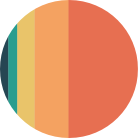

- Short-term memory is caused by the infamous vanishing gradient problem
- As the RNN processes more steps, it has trouble retaining information from previous steps. As you can see, the information from the word “what” and “time” is almost non-existent at the final time step.


Short-Term Memory and the vanishing gradient are due to the nature of back-propagation

Training a neural network has three major steps.

- First, it does a forward pass and makes a prediction.
- Second, it compares the prediction to the ground truth using a loss function. The loss function outputs an error value which is an estimate of how poorly the network is performing.
- Last, it uses that error value to do backpropagation which calculates the gradients for each node in the network.

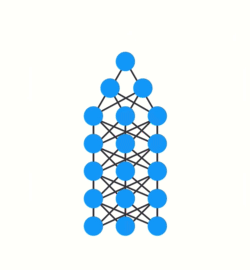


- The gradient is the value used to adjust the network's internal weights, allowing the network to learn. 
- The bigger the gradient, the bigger the adjustments, and vice versa. 
- Here is where the problem lies. When doing backpropagation, each node in a layer calculates its gradient with respect to the effects of the gradients, in the layer before it.

- That causes gradients to exponentially shrink as it back propagates down. 
- The earlier layers fail to do any learning as the internal weights are barely being adjusted due to extremely small gradients. 
- And that’s the vanishing gradient problem.

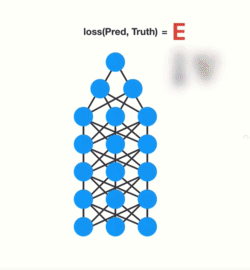

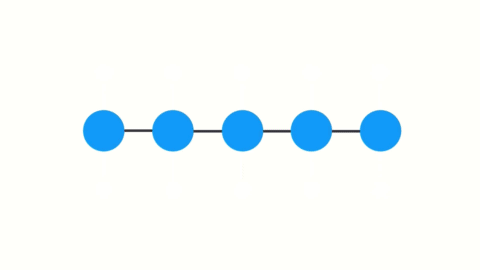

# Better Model - LSTM

Cell state and hidden state

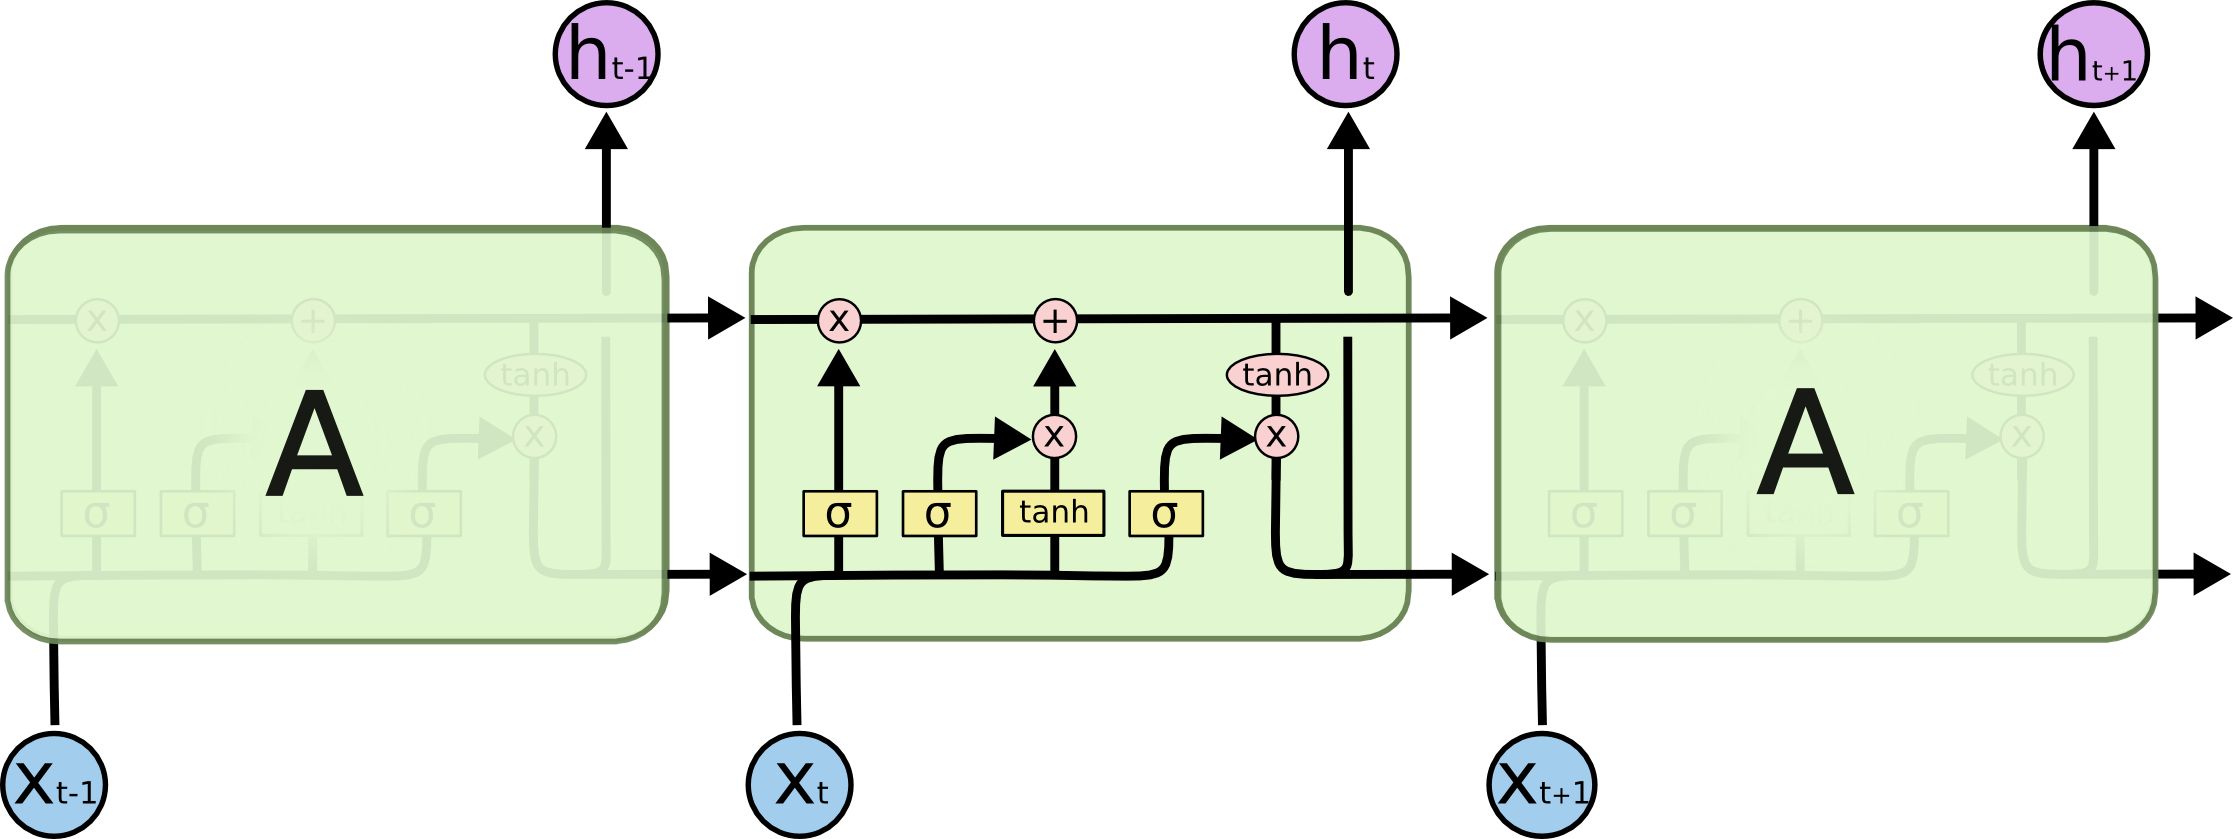

# The Core Idea Behind LSTMs

- The key to LSTMs is the cell state, the horizontal line running through the top of the diagram.
- It doesn't have any interaction with the input.
- It acts like an internal memory where information can be removed or added as required through the mechanism of gates.
- And through this memory mechanism, information can be retained in longer sequences.

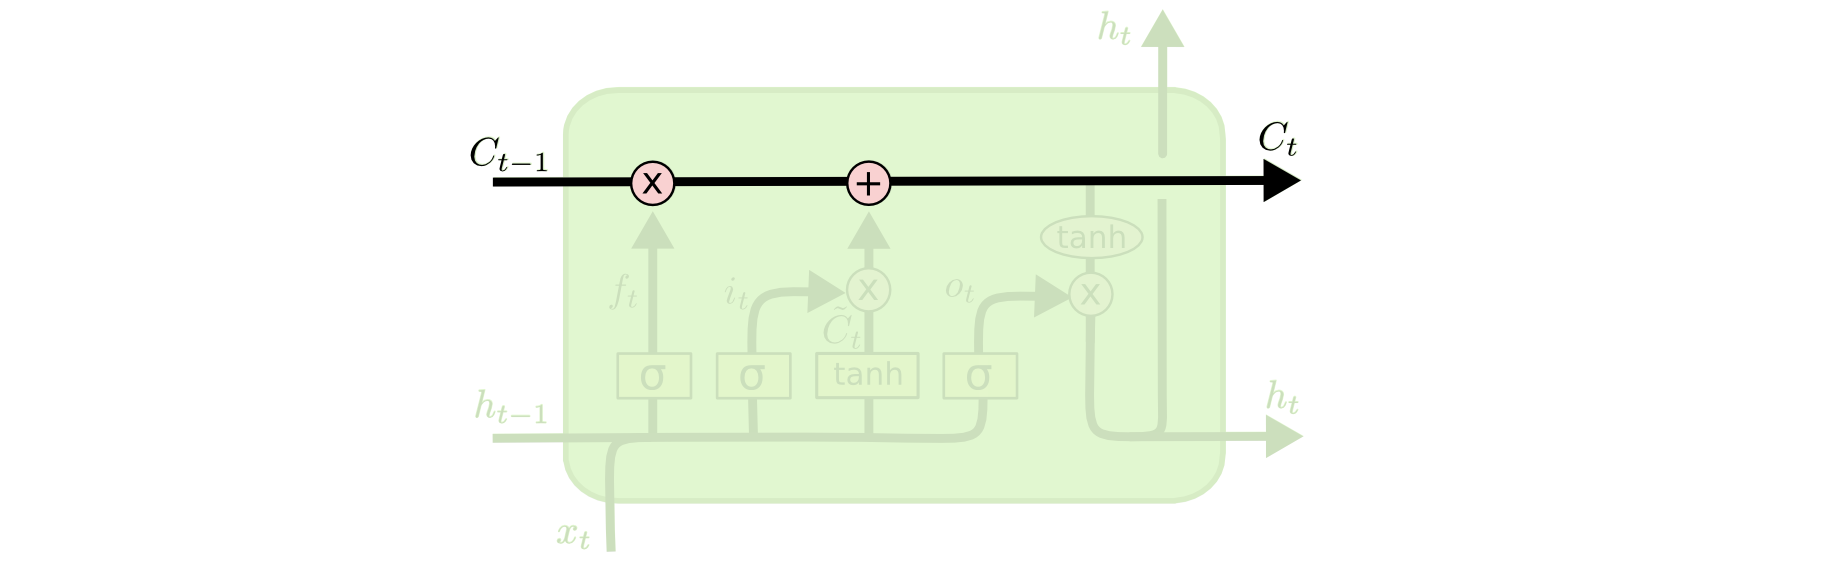

# Attention is all we need

- LSTMs not enough for more complex tasks like machine translation, language models trying to predict next word in sequence(auto complete) etc.
- seq2seq models
- Encoder - Decoder architectures are used for these kind of problems

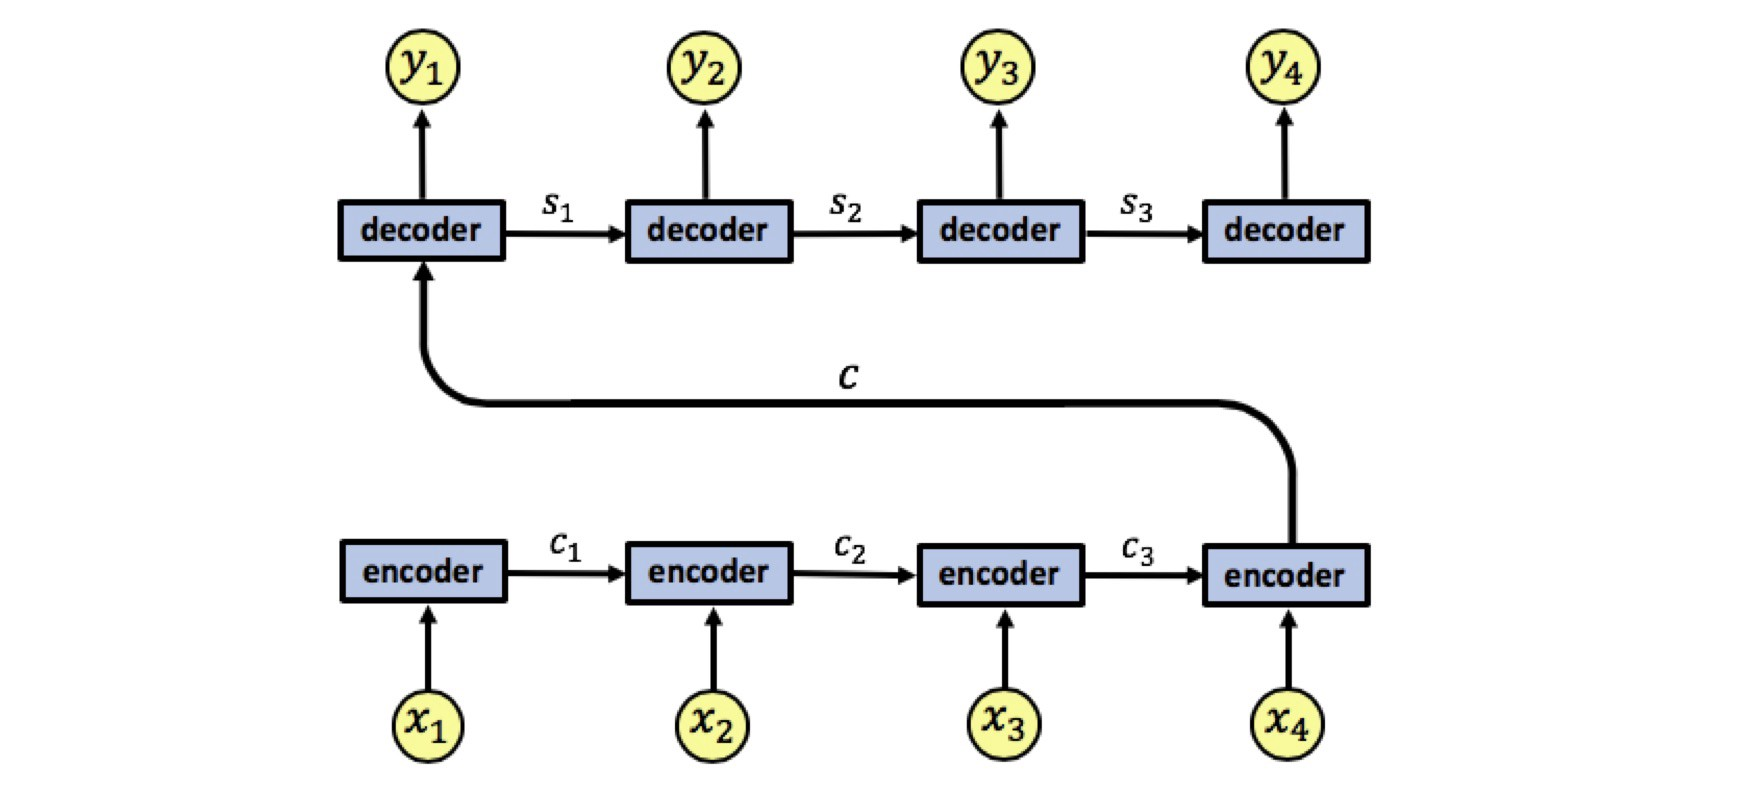

- But it is very difficult to decode multi step output problems from single combined context vector.
- Neural network can solve this problem by attention mechanism.
- Attention mechanism is basically to learn which sub-part of the information to focus on in order to prdict something.

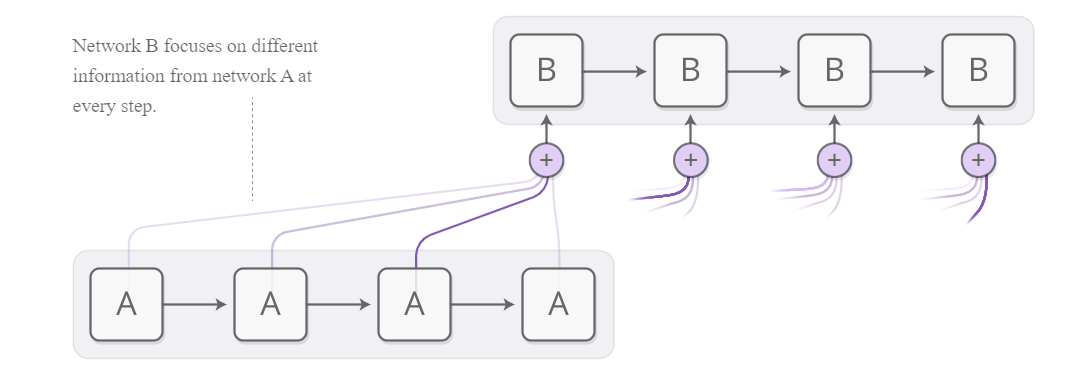

## For Example

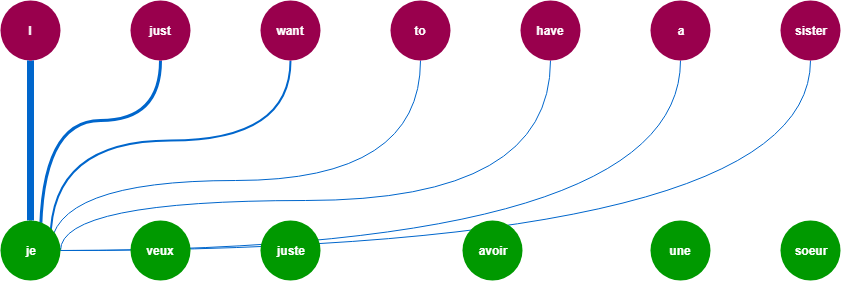

In [10]:
import torch.nn as nn

class classifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        # lengths need to be on CPU!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden)

In [11]:
size_of_vocab = len(TEXT.vocab)
embedding_dim = 100
num_hidden_nodes = 256
num_output_nodes = 7
n_layers = 2
bidirectional = True
dropout = 0.5
pad_idx = TEXT.vocab.stoi[TEXT.pad_token]

model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes, n_layers, bidirectional, dropout, pad_idx)
print(model)

classifier(
  (embedding): Embedding(25002, 100, padding_idx=1)
  (rnn): LSTM(100, 256, num_layers=2, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=7, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [12]:
#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,813,935 trainable parameters


In [13]:
pretrained_embeddings = TEXT.vocab.vectors
# print(pretrained_embeddings.shape)

In [14]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-1.6604e-02, -4.6679e-01,  2.0909e+00,  ..., -1.4692e+00,
          4.4764e-01, -7.2234e-01],
        [-7.9055e-02, -2.0895e-01, -3.4423e-01,  ...,  4.6572e-01,
          6.2975e-01, -1.7395e+00],
        [-9.8863e-01,  2.7295e-01, -2.7247e-01,  ...,  5.3261e-04,
         -2.3852e-03,  3.4945e-01],
        ...,
        [ 3.4111e-01, -4.9119e-01,  3.5234e-03,  ..., -3.0148e-01,
         -9.8976e-02, -3.7355e-01],
        [ 4.8576e-01,  1.4793e+00,  1.2231e+00,  ...,  7.1429e-01,
          7.5398e-01,  7.4644e-01],
        [ 7.0461e-01,  2.3996e-01,  8.6446e-01,  ...,  2.7661e-01,
          8.6563e-03,  6.3138e-01]])

In [15]:
unk_idx = TEXT.vocab.stoi[TEXT.unk_token]
model.embedding.weight.data[unk_idx] = torch.zeros(embedding_dim)
model.embedding.weight.data[pad_idx] = torch.zeros(embedding_dim)

# print(model.embedding.weight.data)

In [16]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

In [17]:
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [18]:
def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    top_pred = preds.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [19]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for batch in iterator:
        optimizer.zero_grad()
        text, text_lengths = batch.text
        predictions = model(text, text_lengths).squeeze()
        loss = criterion(predictions, batch.label)
        acc = categorical_accuracy(predictions, batch.label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [20]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            predictions = model(text, text_lengths).squeeze()
            loss = criterion(predictions, batch.label)
            acc = categorical_accuracy(predictions, batch.label)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [21]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [22]:
N_EPOCHS = 10
best_valid_loss = float('inf')
for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 19s
	Train Loss: 0.620 | Train Acc: 79.64%
	 Val. Loss: 0.430 |  Val. Acc: 86.20%
Epoch: 02 | Epoch Time: 0m 19s
	Train Loss: 0.419 | Train Acc: 86.76%
	 Val. Loss: 0.360 |  Val. Acc: 88.97%
Epoch: 03 | Epoch Time: 0m 19s
	Train Loss: 0.351 | Train Acc: 88.93%
	 Val. Loss: 0.323 |  Val. Acc: 89.92%
Epoch: 04 | Epoch Time: 0m 19s
	Train Loss: 0.311 | Train Acc: 90.18%
	 Val. Loss: 0.295 |  Val. Acc: 90.90%
Epoch: 05 | Epoch Time: 0m 18s
	Train Loss: 0.280 | Train Acc: 91.02%
	 Val. Loss: 0.293 |  Val. Acc: 90.88%
Epoch: 06 | Epoch Time: 0m 19s
	Train Loss: 0.250 | Train Acc: 91.73%
	 Val. Loss: 0.282 |  Val. Acc: 91.10%
Epoch: 07 | Epoch Time: 0m 19s
	Train Loss: 0.231 | Train Acc: 92.41%
	 Val. Loss: 0.281 |  Val. Acc: 91.19%
Epoch: 08 | Epoch Time: 0m 18s
	Train Loss: 0.213 | Train Acc: 92.85%
	 Val. Loss: 0.280 |  Val. Acc: 91.38%
Epoch: 09 | Epoch Time: 0m 19s
	Train Loss: 0.192 | Train Acc: 93.54%
	 Val. Loss: 0.288 |  Val. Acc: 90.92%
Epoch: 10 | Epoch T